## Exact application !!! perfect

--- SetSketch Algorithm Demonstration ---
Common Parameters: m=256, a=20, q=65534
SetSketch (MinHash-like): b=1.001
SetSketch (HLL-like): b=2.0
HyperLogLog for card plots: b_base=2.0

--- 1. Cardinality Estimation Demo (Single Run) ---
Set A (True Cardinality: 1000):
  SetSketch1 (b=1.001) Est. Card: 993.65
  SetSketch2 (b=1.001) Est. Card: 1025.08
  MinHash (Eq16) Est. Card: 980.79
  HLL (b_base=2.0) Est. Card: 1129.95

--- Plotting Cardinality Estimation Error & Theoretical RMSE (m=256) ---


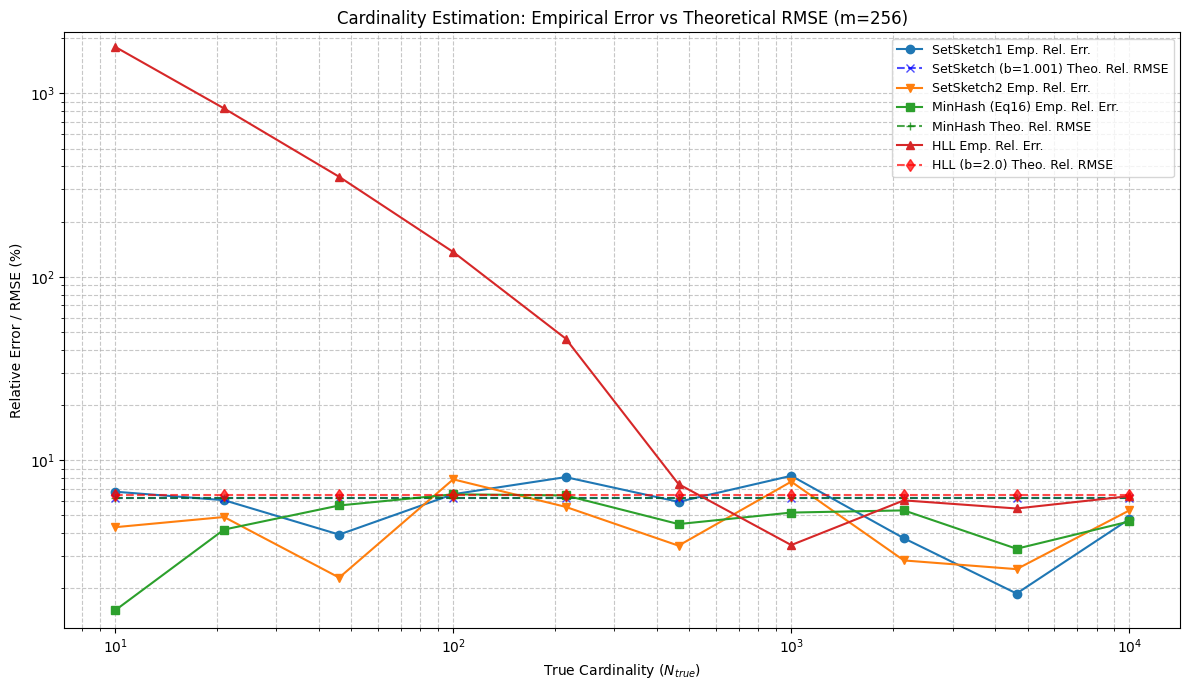


--- 2. Joint Estimation Demo (Single Run) ---
True Jaccard (demo): 0.2000
SetSketch (b=1.001) Est. Jaccard: 0.2351
MinHash Est. Jaccard: 0.2188

--- Plotting Jaccard Estimation Error & Theoretical RMSE (m=256, b=1.001) ---


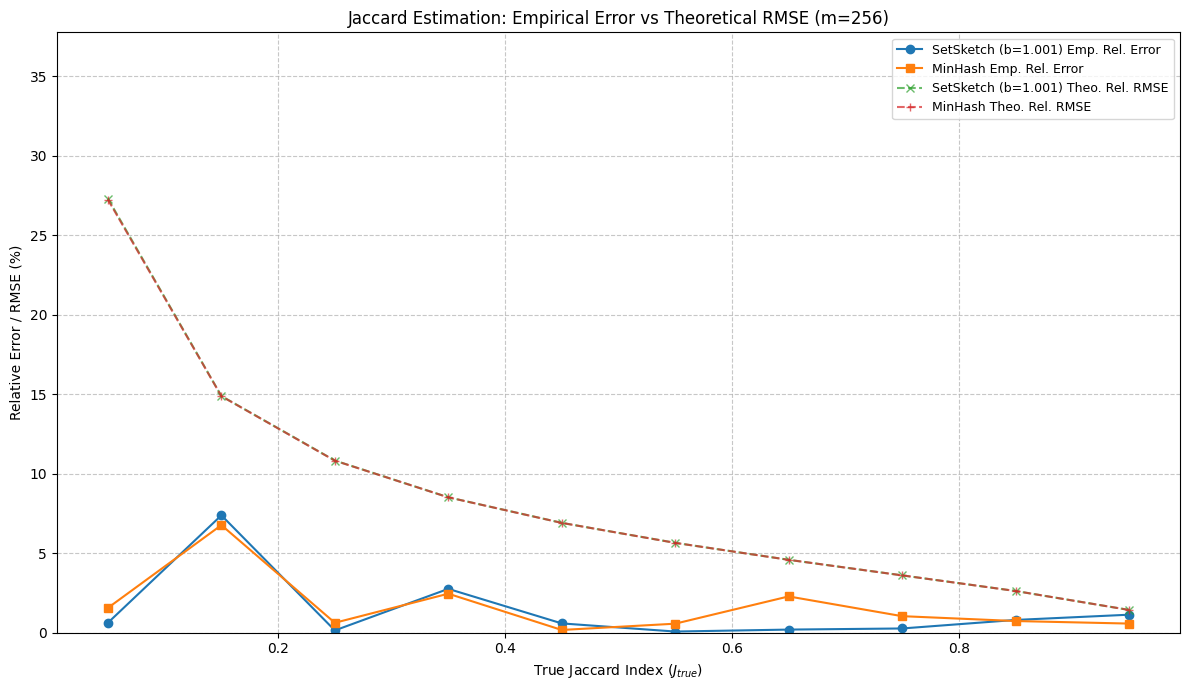


--- Replicating Paper's Figure 2 (Relative Theoretical RMSEs) ---


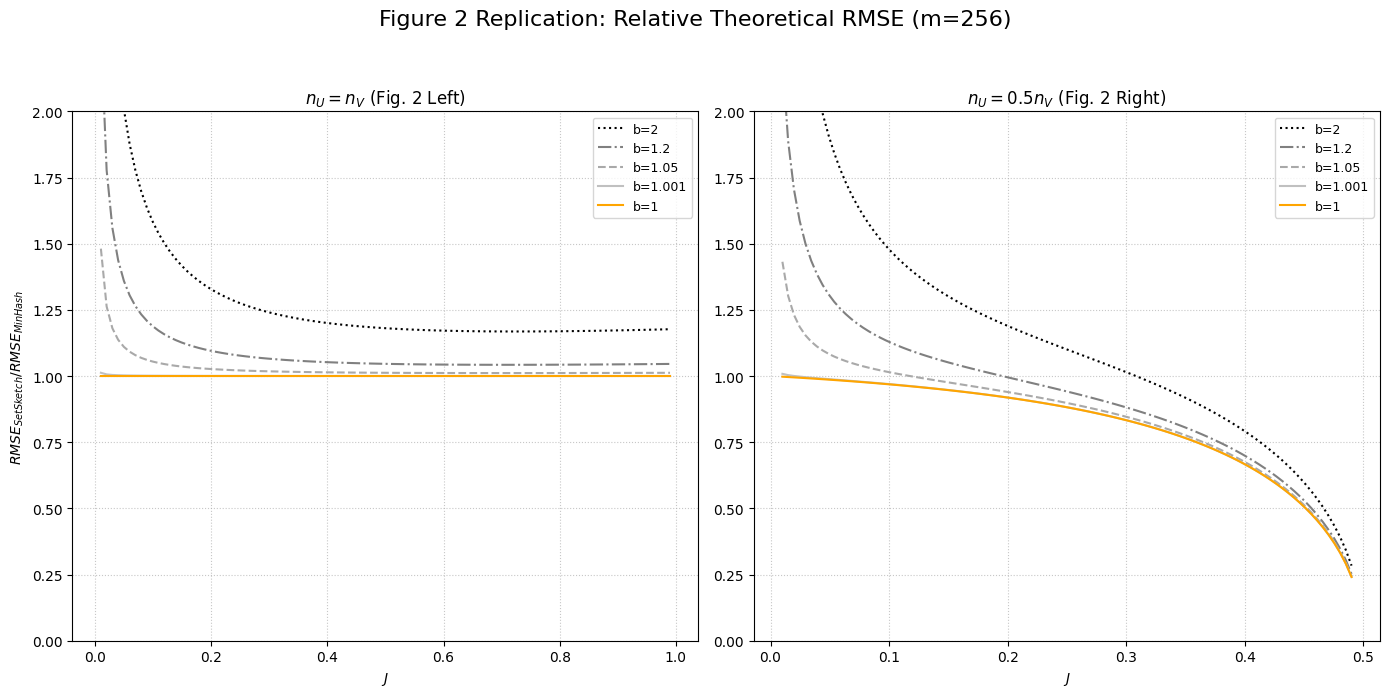


--- Replicating Paper's Figure 3 (Collision Probability Bounds) ---


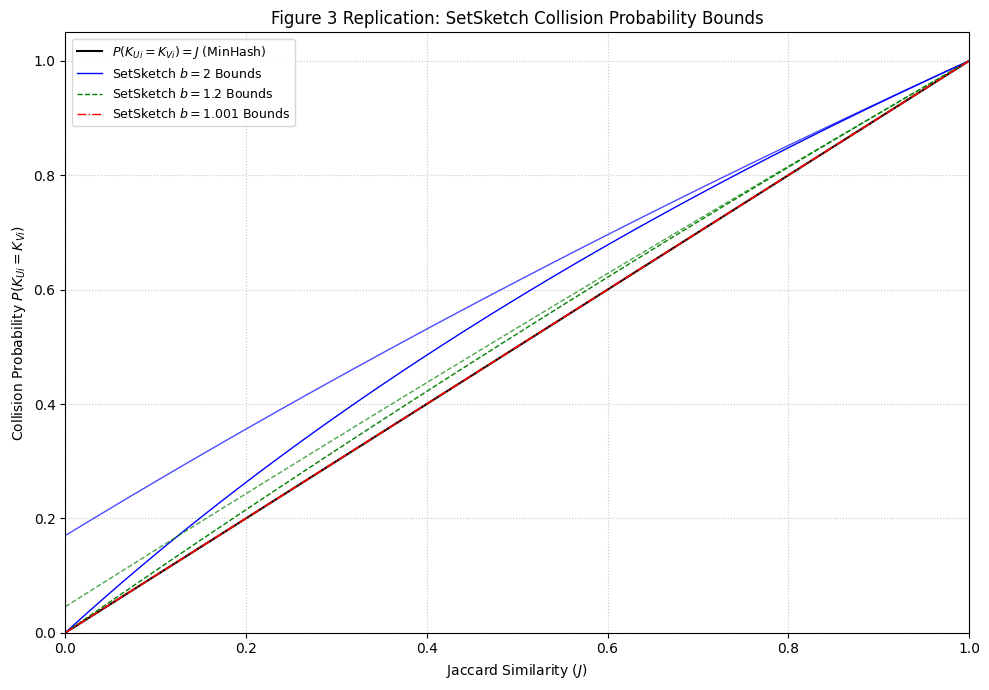


--- Replicating Paper's Figure 4 (RMSE of J_up estimator) ---


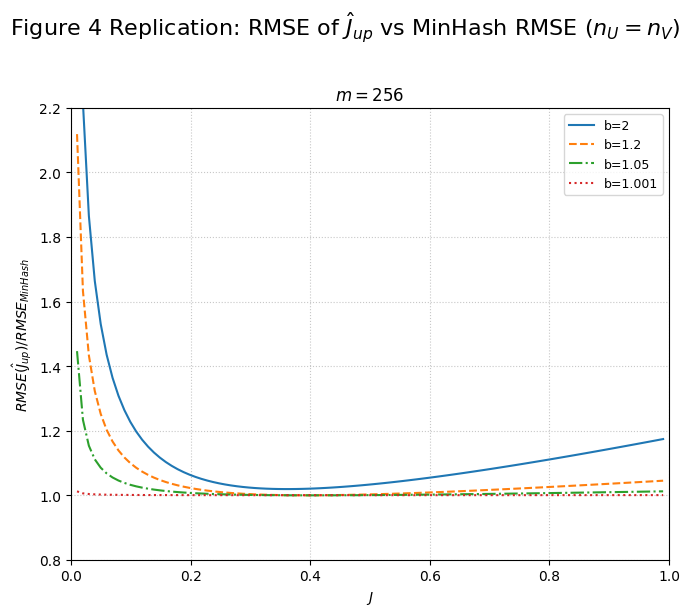


--- Generating Runtime Comparison Plot (Fig. 10 like) ---

--- Plotting Runtime Comparison (Fig. 10 like) ---
Params: m=256, a=20, q=65534, SetSketch b's: [1.001, 2.0]
Cardinalities: 100 to 100000 (8 points)
Runs for averaging time: 3
Measuring runtime for SetSketch with params {'m': 256, 'b': 1.001, 'a': 20, 'q': 65534, 'seed': 894943}, add_method: SetSketch1
  Processed cardinality 1/8 (N=100) -> 1.12e-04 s/elem
  Processed cardinality 2/8 (N=268) -> 8.64e-05 s/elem
  Processed cardinality 3/8 (N=719) -> 6.40e-05 s/elem
  Processed cardinality 4/8 (N=1930) -> 5.67e-05 s/elem
  Processed cardinality 5/8 (N=5179) -> 5.12e-05 s/elem
  Processed cardinality 6/8 (N=13894) -> 4.98e-05 s/elem
  Processed cardinality 7/8 (N=37275) -> 4.86e-05 s/elem
  Processed cardinality 8/8 (N=100000) -> 4.94e-05 s/elem
Measuring runtime for SetSketch with params {'m': 256, 'b': 1.001, 'a': 20, 'q': 65534, 'seed': 894943}, add_method: SetSketch2
  Processed cardinality 1/8 (N=100) -> 1.53e-04 s/elem
  Pr

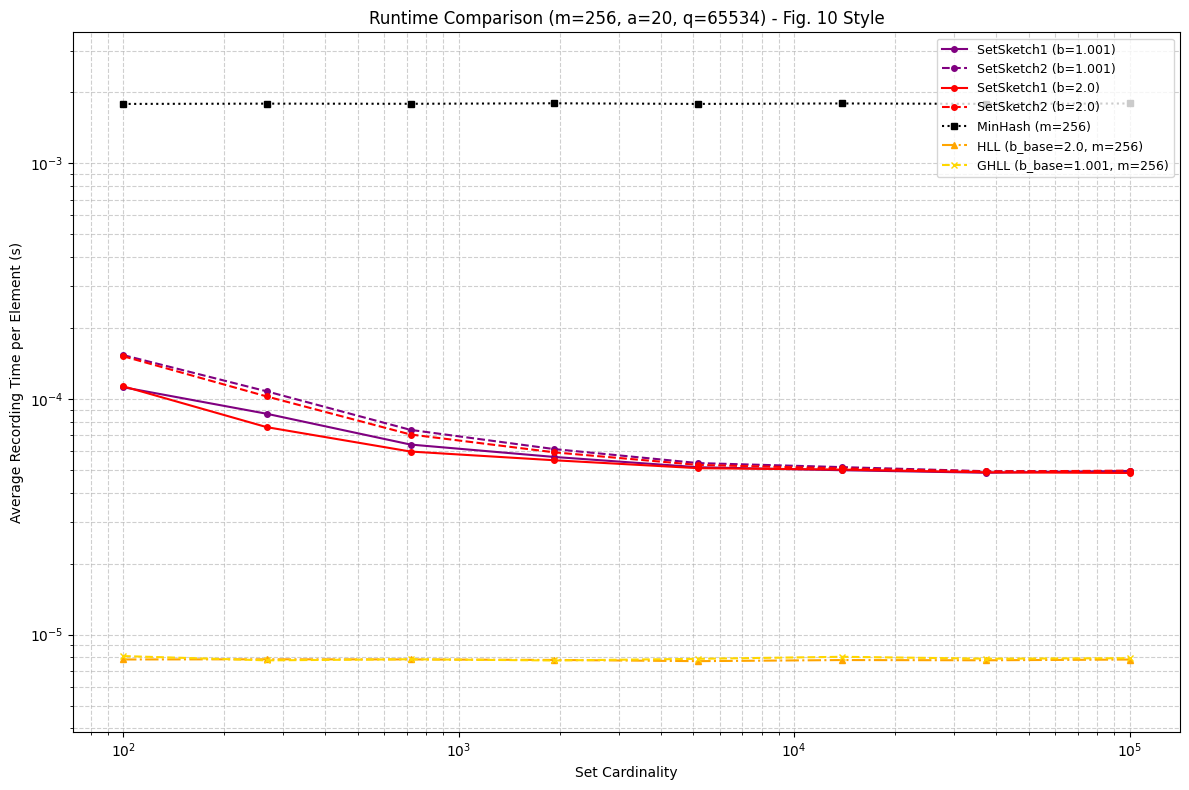


--- End of Demonstration ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize_scalar
import math
import time

# --- Helper Utilities ---
def get_item_seed(item):
    """Generates a seed from an item."""
    return hash(item)

def log_b_np(x, b_val): 
    """Calculates log base b for numpy arrays, handling edge cases."""
    x_safe = np.maximum(x, 1e-300) 
    b_log_safe = np.log(b_val)
    if b_log_safe == 0: return np.full_like(x_safe, float('inf')) 
    return np.log(x_safe) / b_log_safe

# --- Theoretical Calculation Helper Functions ---
def p_b_theoretical(x, b_val):
    """
    Theoretical p_b(x) = -log_b(1 - x * (b-1)/b) from SetSketch paper.
    Handles numpy arrays and edge cases for numerical stability.
    """
    if b_val == 1: return np.maximum(0, np.asarray(x)) 
    
    x_arr = np.asarray(x)
    arg = 1 - x_arr * (b_val - 1) / b_val
    
    arg = np.maximum(arg, 1e-9) 
    
    log_b_val = np.log(b_val)
    if log_b_val == 0: return np.full_like(arg, float('inf')) 
    
    return -np.log(arg) / log_b_val

def p_b_prime_theoretical(x, b_val):
    """
    Theoretical derivative p_b'(x) from SetSketch paper.
    """
    if b_val == 1: return np.ones_like(np.asarray(x)) 
    
    x_arr = np.asarray(x)
    denominator_in_arg = 1 - x_arr * (b_val - 1) / b_val
    denominator_in_arg = np.maximum(denominator_in_arg, 1e-9) 

    log_b_val = np.log(b_val)
    if log_b_val == 0: return np.full_like(x_arr, float('inf'))

    return (b_val - 1) / (b_val * log_b_val * denominator_in_arg)

def fisher_information_setsketch(J_val, b_val, u, v, m_registers):
    """
    Calculates Fisher Information I(J) for SetSketch's ML estimator (Lemma 15).
    """
    J_arr = np.asarray(J_val)
    arg1 = u - v * J_arr
    arg2 = v - u * J_arr
    epsilon = 1e-9

    valid_x_upper_bound = (b_val / (b_val - 1.0)) - epsilon if b_val > 1.00001 else 1.0 - epsilon
    arg1 = np.clip(arg1, 0, valid_x_upper_bound)
    arg2 = np.clip(arg2, 0, valid_x_upper_bound)

    pb_arg1 = p_b_theoretical(arg1, b_val)
    pb_arg2 = p_b_theoretical(arg2, b_val)

    pb_arg1_safe = np.maximum(pb_arg1, epsilon)
    pb_arg2_safe = np.maximum(pb_arg2, epsilon)

    pb_prime_arg1 = p_b_prime_theoretical(arg1, b_val)
    pb_prime_arg2 = p_b_prime_theoretical(arg2, b_val)

    term1_num = (v * pb_prime_arg1)**2
    term1 = term1_num / pb_arg1_safe

    term2_num = (u * pb_prime_arg2)**2
    term2 = term2_num / pb_arg2_safe

    pb0 = 1 - pb_arg1 - pb_arg2
    pb0_safe = np.maximum(pb0, epsilon)

    term3_num = (v * pb_prime_arg1 + u * pb_prime_arg2)**2
    term3 = term3_num / pb0_safe
    
    I_J = m_registers * (term1 + term2 + term3)
    return np.maximum(I_J, epsilon) 

# --- Sketch Implementations ---
class SetSketch:
    def __init__(self, m, b, a, q, seed=None):
        if not (b > 1): raise ValueError("Base b must be > 1.")
        if not (a > 0): raise ValueError("Rate a must be > 0.")
        if not (m > 0 and isinstance(m, int)): raise ValueError("Number of registers m must be a positive integer.")
        if not (q >= 0 and isinstance(q, int)): raise ValueError("Parameter q must be a non-negative integer.")
        self.m = m
        self.b = b
        self.a = a
        self.q = q
        self.registers = np.zeros(m, dtype=int)
        self.K_low = 0
        self.w = 0
        self._master_prng = random.Random(seed) 
        self._log_b = math.log(b) 

    def _get_jth_ordered_exp_hash_setsketch2(self, item_prng, j_order_stat_zero_indexed):
        j_one_idx = j_order_stat_zero_indexed + 1
        gamma_prev = 0
        if j_one_idx > 1:
            denominator_gamma_prev = self.m - (j_one_idx - 1)
            if denominator_gamma_prev > 0:
                gamma_prev = (1/self.a) * math.log(1 + (j_one_idx - 1) / denominator_gamma_prev)
            else: 
                gamma_prev = float('inf') 
        
        gamma_curr = float('inf')
        if j_one_idx < self.m:
            denominator_gamma_curr = self.m - j_one_idx
            if denominator_gamma_curr > 0:
                gamma_curr = (1/self.a) * math.log(1 + j_one_idx / denominator_gamma_curr)
        
        u = item_prng.random() 

        if gamma_curr == float('inf'): 
            return gamma_prev - math.log(1-u) / self.a
        else: 
            if gamma_curr > gamma_prev:
                val_in_log = 1 - u * (1 - math.exp(-self.a * (gamma_curr - gamma_prev)))
                if val_in_log <= 1e-9: return gamma_prev 
                return gamma_prev - math.log(val_in_log) / self.a
            else: 
                return gamma_prev 

    def add(self, item, method='SetSketch1'):
        item_seed = get_item_seed(item)
        item_prng = random.Random(item_seed)
        permuted_indices = list(range(self.m))
        item_prng.shuffle(permuted_indices) 

        current_x_val_ss1 = 0.0 

        for j_loop_idx in range(self.m): 
            if method == 'SetSketch1':
                j_one_indexed_for_spacing = j_loop_idx + 1
                denominator = self.m + 1 - j_one_indexed_for_spacing
                if denominator <= 0: break 
                spacing = item_prng.expovariate(self.a) / denominator
                current_x_val_ss1 += spacing
                x_val = current_x_val_ss1
            elif method == 'SetSketch2':
                x_val = self._get_jth_ordered_exp_hash_setsketch2(item_prng, j_loop_idx)
            else:
                raise ValueError("Invalid method specified for SetSketch.add.")
            
            if self.K_low > 0:
                if x_val <= 1e-300: 
                    pass 
                elif (math.log(x_val) / self._log_b) > -self.K_low:
                    break
            elif x_val > 1.0 : 
                break
            
            if x_val <= 1e-300: k_val = self.q + 1 
            else: k_val = math.floor(1 - (math.log(x_val) / self._log_b))
            k_val = max(0, min(self.q + 1, k_val))

            if k_val <= self.K_low: 
                break
            
            target_register_idx = permuted_indices[j_loop_idx]
            if k_val > self.registers[target_register_idx]:
                self.registers[target_register_idx] = k_val
                self.w += 1
            
        if self.w >= self.m: 
            self.K_low = int(np.min(self.registers))
            self.w = 0

    def merge(self, other_sketch):
        if not (self.m == other_sketch.m and self.b == other_sketch.b and \
                self.a == other_sketch.a and self.q == other_sketch.q):
            raise ValueError("SetSketches must have identical parameters to be merged.")
        self.registers = np.maximum(self.registers, other_sketch.registers)
        self.K_low = int(np.min(self.registers))
        self.w = 0

    def estimate_cardinality(self):
        if self.a == 0 or self._log_b == 0: return float('nan')
        sum_b_neg_K_i = np.sum(self.b ** (-self.registers.astype(float)))
        if abs(sum_b_neg_K_i) < 1e-300: return float('inf')
        numerator = self.m * (1 - (1/self.b))
        denominator = self.a * self._log_b * sum_b_neg_K_i
        if abs(denominator) < 1e-300: return float('inf')
        return numerator / denominator

    def _p_b_internal(self, x_val): 
        arg = 1 - x_val * (self.b - 1) / self.b
        if arg <= 1e-9: return 1000.0 
        return -math.log(arg) / self._log_b

    def estimate_joint_quantities(self, other_sketch, n_U_est=None, n_V_est=None):
        if not (self.m == other_sketch.m and self.b == other_sketch.b):
                 raise ValueError("Sketches must have same m and b for joint estimation.")
        if n_U_est is None: n_U_est = self.estimate_cardinality()
        if n_V_est is None: n_V_est = other_sketch.estimate_cardinality()

        n_U_est = max(1e-6, n_U_est) 
        n_V_est = max(1e-6, n_V_est)

        D_plus = np.sum(self.registers > other_sketch.registers)
        D_minus = np.sum(self.registers < other_sketch.registers)
        D_zero = self.m - D_plus - D_minus
        
        sum_n_uv = n_U_est + n_V_est
        u_rel = n_U_est / sum_n_uv
        v_rel = n_V_est / sum_n_uv

        def neg_log_likelihood(J):
            J = np.clip(J, 1e-9, 1.0 - 1e-9)
            arg1 = u_rel - v_rel * J
            arg2 = v_rel - u_rel * J
            if arg1 < -1e-7 or arg2 < -1e-7: return 1e18 
            
            pb_arg1 = self._p_b_internal(max(0, arg1))
            pb_arg2 = self._p_b_internal(max(0, arg2))
            
            log_term1 = D_plus * math.log(pb_arg1 + 1e-9) if pb_arg1 > -1e-9 else (-1e18 if D_plus > 0 else 0)
            log_term2 = D_minus * math.log(pb_arg2 + 1e-9) if pb_arg2 > -1e-9 else (-1e18 if D_minus > 0 else 0)
            
            p0_approx = 1 - pb_arg1 - pb_arg2
            if p0_approx <= 1e-9: log_term3 = (-1e18 if D_zero > 0 else 0)
            else: log_term3 = D_zero * math.log(p0_approx)
            
            neg_L = -(log_term1 + log_term2 + log_term3)
            return neg_L if not (math.isinf(neg_L) or math.isnan(neg_L)) else 1e18

        upper_bound_J = 1.0
        if v_rel > 1e-9 and u_rel > 1e-9: upper_bound_J = min(u_rel/v_rel, v_rel/u_rel, 1.0)
        elif v_rel <= 1e-9 or u_rel <= 1e-9: upper_bound_J = 1e-6
        
        opt_bounds = (1e-9, max(1e-9 + 1e-6, upper_bound_J - 1e-6))
        if opt_bounds[0] >= opt_bounds[1]: opt_bounds = (1e-9, 1.0-1e-9)

        J_est_mle = D_zero / self.m 
        try:
            res = minimize_scalar(neg_log_likelihood, bounds=opt_bounds, method='bounded')
            if res.success: J_est_mle = res.x
        except Exception: pass 
        
        J_est_mle = np.clip(J_est_mle, 0, 1.0)
        union_size_est = (n_U_est + n_V_est) / (1 + J_est_mle + 1e-9)
        intersection_size_est = union_size_est * J_est_mle
        return {'jaccard': J_est_mle, 'union_size': union_size_est, 'intersection_size': intersection_size_est,
                'n_U_est': n_U_est, 'n_V_est': n_V_est, 'D_plus': int(D_plus), 'D_minus': int(D_minus), 'D_zero': int(D_zero)}

    def __str__(self):
        return (f"SetSketch(m={self.m}, b={self.b}, a={self.a}, q={self.q}, "
                f"K_low={self.K_low}, w={self.w}\n"
                f"Registers: {self.registers[:10]}... (first 10 shown))")

class MinHash:
    def __init__(self, num_hashes, seed=None):
        self.num_hashes = num_hashes
        self.minhash_values = np.full(num_hashes, float('inf'))
        self._master_prng = random.Random(seed)
        self.hash_seeds = [self._master_prng.getrandbits(32) for _ in range(num_hashes)]
    def add(self, item):
        item_val_for_hash = get_item_seed(item)
        for i in range(self.num_hashes):
            current_prng = random.Random(item_val_for_hash + self.hash_seeds[i])
            hash_val = current_prng.getrandbits(64)
            if hash_val < self.minhash_values[i]: self.minhash_values[i] = hash_val
    def jaccard(self, other_minhash):
        if self.num_hashes != other_minhash.num_hashes:
            raise ValueError("MinHash sketches must have the same number of hash functions.")
        if self.num_hashes == 0: return 0.0
        matches = np.sum(self.minhash_values == other_minhash.minhash_values)
        return matches / self.num_hashes
    def estimate_cardinality_paper_eq16(self):
        MAX_HASH_VAL = 2**64 -1
        valid_hashes = self.minhash_values[self.minhash_values != float('inf')]
        if len(valid_hashes) == 0: return 0.0
        K_prime = valid_hashes / MAX_HASH_VAL
        K_prime = np.clip(K_prime, 1e-9, 1.0 - 1e-9)
        sum_log_terms = np.sum(-np.log(1 - K_prime))
        if abs(sum_log_terms) < 1e-9: return float('inf')
        return self.num_hashes / sum_log_terms

class HyperLogLog: 
    def __init__(self, m_bits, b_base=2, seed=None):
        self.p_bits = m_bits 
        self.m = 1 << m_bits
        self.b_base = b_base
        self.registers = np.zeros(self.m, dtype=int)
        self._master_prng = random.Random(seed)
        self.hash_seed_hll = self._master_prng.getrandbits(32)
        self._log_b_base = math.log(self.b_base) if self.b_base > 1 else 0

    def add(self, item):
        item_val_for_hash = get_item_seed(item)
        prng = random.Random(item_val_for_hash + self.hash_seed_hll)
        hash_val_64bit = prng.getrandbits(64)
        register_index = hash_val_64bit & (self.m - 1)
        
        h2_d_int = hash_val_64bit >> self.p_bits
        h2_d_float = (h2_d_int + 0.5) / (1 << (64 - self.p_bits)) 
        h2_d_float = max(1e-9, h2_d_float) 
        
        if self._log_b_base == 0: return 
        val_to_calc = 1 - (math.log(h2_d_float) / self._log_b_base)
        update_value = math.floor(val_to_calc)
        update_value = max(0, update_value) 
        
        if update_value > self.registers[register_index]:
            self.registers[register_index] = update_value

    def estimate_cardinality(self):
        a_hll = 1.0 / self.m
        if a_hll == 0 or self._log_b_base == 0: return float('nan')
        
        sum_b_neg_K_i = np.sum(self.b_base ** (-self.registers.astype(float)))
        if abs(sum_b_neg_K_i) < 1e-300: return float('inf') 

        numerator = self.m * (1 - (1/self.b_base))
        denominator = a_hll * self._log_b_base * sum_b_neg_K_i
        if abs(denominator) < 1e-300: return float('inf')
        
        card_est = numerator / denominator

        V = np.sum(self.registers == 0) 
        if V > 0: 
            if card_est < 5 * self.m : 
                if V < self.m : 
                    card_est_lc = self.m * math.log(self.m / V)
                    if card_est < self.m / 10 or card_est < 0: 
                        card_est = card_est_lc
                elif V == self.m: 
                    card_est = 0.0 
        return card_est

# --- Runtime Measurement Function ---
def measure_recording_time(sketch_class_constructor, sketch_params, cardinalities, 
                           num_runs_for_avg_time=3, sketch_add_method_name=None, 
                           item_prefix="time_item"):
    """
    Measures average recording time per element for a given sketch.
    Excludes initialization time. Items are generated on the fly.
    """
    avg_times_per_element = []
    print(f"Measuring runtime for {sketch_class_constructor.__name__} with params {sketch_params}, add_method: {sketch_add_method_name}")

    for card_idx, card in enumerate(cardinalities):
        run_times_for_card = []
        if card == 0: 
            avg_times_per_element.append(0.0)
            if (card_idx + 1) % max(1, len(cardinalities)//5) == 0 or card_idx == len(cardinalities)-1 : 
                 print(f"  Processed cardinality {card_idx+1}/{len(cardinalities)} (N={card}) -> 0.0 s/elem")
            continue

        for r in range(num_runs_for_avg_time):
            
            current_run_seed = sketch_params.get('seed', None)
            if current_run_seed is not None:
                temp_sketch_params = {**sketch_params, 'seed': current_run_seed + r + card} 
            else:
                temp_sketch_params = {**sketch_params}

            sketch_instance = sketch_class_constructor(**temp_sketch_params)
            
            items_to_add = (f"{item_prefix}_{card}_{r}_{i}" for i in range(card))

            start_time = time.perf_counter()
            if sketch_add_method_name:
                add_op = getattr(sketch_instance, 'add')
                for item in items_to_add:
                    add_op(item, method=sketch_add_method_name)
            else:
                add_op = getattr(sketch_instance, 'add')
                for item in items_to_add:
                    add_op(item)
            end_time = time.perf_counter()
            
            total_time_for_run = end_time - start_time
            time_per_element_for_run = total_time_for_run / card if card > 0 else 0
            run_times_for_card.append(time_per_element_for_run)
        
        avg_time_for_card = np.mean(run_times_for_card)
        avg_times_per_element.append(avg_time_for_card)
        if (card_idx + 1) % max(1, len(cardinalities)//5) == 0 or card_idx == len(cardinalities)-1 :
            print(f"  Processed cardinality {card_idx+1}/{len(cardinalities)} (N={card}) -> {avg_time_for_card:.2e} s/elem")
            
    return avg_times_per_element

# --- Plotting Functions ---
def plot_cardinality_errors_and_rmse(m_param, b_param_ss, a_param_ss, q_param_ss, b_param_hll):
    print(f"\n--- Plotting Cardinality Estimation Error & Theoretical RMSE (m={m_param}) ---")
    true_cardinalities = np.logspace(1, 4, 10, dtype=int) 
    
    ss1_emp_err, ss2_emp_err, mh_emp_err, hll_emp_err = [], [], [], []
    ss_theo_rel_rmse, mh_theo_rel_rmse, hll_theo_rel_rmse = [], [], []

    num_runs_for_empirical = 5 

    for card in true_cardinalities:
        run_ss1_ests, run_ss2_ests, run_mh_ests, run_hll_ests = [], [], [], []
        for r_idx in range(num_runs_for_empirical):
            items = {f"item_plot_{card}_{r_idx}_{i}" for i in range(card)}
            seed_base = random.randint(0, 2**30)

            temp_ss1 = SetSketch(m_param, b_param_ss, a_param_ss, q_param_ss, seed=seed_base)
            temp_ss2 = SetSketch(m_param, b_param_ss, a_param_ss, q_param_ss, seed=seed_base) 
            temp_mh = MinHash(num_hashes=m_param, seed=seed_base)
            temp_hll = HyperLogLog(m_bits=int(np.log2(m_param)), b_base=b_param_hll, seed=seed_base)
            
            for item in items:
                temp_ss1.add(item, 'SetSketch1')
                temp_ss2.add(item, 'SetSketch2')
                temp_mh.add(item)
                temp_hll.add(item)
            
            run_ss1_ests.append(temp_ss1.estimate_cardinality())
            run_ss2_ests.append(temp_ss2.estimate_cardinality())
            run_mh_ests.append(temp_mh.estimate_cardinality_paper_eq16())
            run_hll_ests.append(temp_hll.estimate_cardinality())
        
        if card > 0:
            ss1_emp_err.append(np.mean(np.abs(np.array(run_ss1_ests) - card)) / card * 100)
            ss2_emp_err.append(np.mean(np.abs(np.array(run_ss2_ests) - card)) / card * 100)
            mh_emp_err.append(np.mean(np.abs(np.array(run_mh_ests) - card)) / card * 100)
            hll_emp_err.append(np.mean(np.abs(np.array(run_hll_ests) - card)) / card * 100)
        else: 
            ss1_emp_err.append(np.mean(np.abs(np.array(run_ss1_ests))) * 100 if card == 0 else 0) 
            ss2_emp_err.append(np.mean(np.abs(np.array(run_ss2_ests)))* 100 if card == 0 else 0)
            mh_emp_err.append(np.mean(np.abs(np.array(run_mh_ests)))* 100 if card == 0 else 0)
            hll_emp_err.append(np.mean(np.abs(np.array(run_hll_ests)))* 100 if card == 0 else 0)

        log_b_ss = math.log(b_param_ss)
        if b_param_ss > 1.00001 and log_b_ss > 1e-9 : 
            rsd_ss_theo = math.sqrt((1/m_param) * (((b_param_ss + 1) / (b_param_ss - 1)) * log_b_ss - 1))
            ss_theo_rel_rmse.append(rsd_ss_theo * 100)
        else: 
            ss_theo_rel_rmse.append((1/math.sqrt(m_param)) * 100)

        rsd_mh_theo = 1 / math.sqrt(m_param)
        mh_theo_rel_rmse.append(rsd_mh_theo * 100)

        log_b_hll = math.log(b_param_hll)
        if b_param_hll > 1.00001 and log_b_hll > 1e-9:
            rsd_hll_theo = math.sqrt((1/m_param) * (((b_param_hll + 1) / (b_param_hll - 1)) * log_b_hll - 1))
            hll_theo_rel_rmse.append(rsd_hll_theo * 100)
        else: 
            hll_theo_rel_rmse.append((1/math.sqrt(m_param)) * 100)

    plt.figure(figsize=(12,7))
    plt.plot(true_cardinalities, ss1_emp_err, marker='o', linestyle='-', label='SetSketch1 Emp. Rel. Err.')
    plt.plot(true_cardinalities, ss_theo_rel_rmse, marker='x', linestyle='--', color='blue', alpha=0.7, label=f'SetSketch (b={b_param_ss}) Theo. Rel. RMSE')
    plt.plot(true_cardinalities, ss2_emp_err, marker='v', linestyle='-', label='SetSketch2 Emp. Rel. Err.')
    plt.plot(true_cardinalities, mh_emp_err, marker='s', linestyle='-', label='MinHash (Eq16) Emp. Rel. Err.')
    plt.plot(true_cardinalities, mh_theo_rel_rmse, marker='+', linestyle='--', color='green', alpha=0.7, label='MinHash Theo. Rel. RMSE')
    plt.plot(true_cardinalities, hll_emp_err, marker='^', linestyle='-', label='HLL Emp. Rel. Err.')
    plt.plot(true_cardinalities, hll_theo_rel_rmse, marker='d', linestyle='--', color='red', alpha=0.7, label=f'HLL (b={b_param_hll}) Theo. Rel. RMSE')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('True Cardinality ($N_{true}$)')
    plt.ylabel('Relative Error / RMSE (%)')
    plt.title(f'Cardinality Estimation: Empirical Error vs Theoretical RMSE (m={m_param})')
    plt.legend(fontsize=9)
    plt.grid(True, which="both", ls="--", alpha=0.7)
    all_errors_for_ylim = ss1_emp_err + ss2_emp_err + mh_emp_err + hll_emp_err + ss_theo_rel_rmse + mh_theo_rel_rmse + hll_theo_rel_rmse
    valid_ylim_errors = [e for e in all_errors_for_ylim if e is not None and not (math.isinf(e) or math.isnan(e)) and e > 0]
    if valid_ylim_errors:
        plt.ylim(bottom=min(valid_ylim_errors)*0.8, top=max(valid_ylim_errors)*1.2)
    plt.tight_layout()
    plt.show()

def plot_jaccard_errors_and_rmse(m_param, b_param_ss, a_param_ss, q_param_ss):
    print(f"\n--- Plotting Jaccard Estimation Error & Theoretical RMSE (m={m_param}, b={b_param_ss}) ---")
    true_jaccards_plot = np.linspace(0.05, 0.95, 10)
    ss_empirical_rel_errors, mh_empirical_rel_errors = [], []
    ss_theoretical_rel_errors, mh_theoretical_rel_errors = [], []
    base_set_size_plot = 5000
    num_runs_for_empirical = 5 

    for tj_plot in true_jaccards_plot:
        run_ss_j_ests, run_mh_j_ests = [], []
        for r_idx in range(num_runs_for_empirical):
            n_intersect_plot = int(tj_plot * (base_set_size_plot + base_set_size_plot) / (1 + tj_plot))
            n_A_only_plot = base_set_size_plot - n_intersect_plot
            n_B_only_plot = base_set_size_plot - n_intersect_plot
            items_A_plot = {f"common_plot_{tj_plot}_{r_idx}_{i}" for i in range(n_intersect_plot)} | \
                           {f"A_plot_{tj_plot}_{r_idx}_{i}" for i in range(n_A_only_plot)}
            items_B_plot = {f"common_plot_{tj_plot}_{r_idx}_{i}" for i in range(n_intersect_plot)} | \
                           {f"B_plot_{tj_plot}_{r_idx}_{i}" for i in range(n_B_only_plot)}
            
            seed_ssA = random.randint(0, 2**30)
            seed_ssB = random.randint(0, 2**30)
            seed_mh_shared = random.randint(0, 2**30)

            temp_ssA = SetSketch(m_param, b_param_ss, a_param_ss, q_param_ss, seed=seed_ssA)
            temp_ssB = SetSketch(m_param, b_param_ss, a_param_ss, q_param_ss, seed=seed_ssB)
            temp_mhA = MinHash(num_hashes=m_param, seed=seed_mh_shared)
            temp_mhB = MinHash(num_hashes=m_param, seed=seed_mh_shared)

            for item in items_A_plot: temp_ssA.add(item); temp_mhA.add(item)
            for item in items_B_plot: temp_ssB.add(item); temp_mhB.add(item)
            
            run_ss_j_ests.append(temp_ssA.estimate_joint_quantities(temp_ssB)['jaccard'])
            run_mh_j_ests.append(temp_mhA.jaccard(temp_mhB))

        est_j_ss_avg = np.mean(run_ss_j_ests)
        est_j_mh_avg = np.mean(run_mh_j_ests)
        
        if tj_plot > 1e-9:
            ss_empirical_rel_errors.append(abs(est_j_ss_avg - tj_plot) / tj_plot * 100)
            mh_empirical_rel_errors.append(abs(est_j_mh_avg - tj_plot) / tj_plot * 100)
        else:
            ss_empirical_rel_errors.append(abs(est_j_ss_avg) * 100 if tj_plot == 0 else 0)
            mh_empirical_rel_errors.append(abs(est_j_mh_avg) * 100 if tj_plot == 0 else 0)

        if tj_plot > 1e-9 and (1 - tj_plot) > 1e-9:
            rmse_mh_theoretical = math.sqrt(tj_plot * (1 - tj_plot) / m_param)
            mh_theoretical_rel_errors.append((rmse_mh_theoretical / tj_plot) * 100)
        else: mh_theoretical_rel_errors.append(0 if tj_plot < 1e-9 else float('inf'))

        u_th, v_th = 0.5, 0.5 
        I_J_ss = fisher_information_setsketch(tj_plot, b_param_ss, u_th, v_th, m_param)
        if I_J_ss > 1e-9:
            rmse_ss_theoretical = 1 / math.sqrt(I_J_ss)
            if tj_plot > 1e-9: ss_theoretical_rel_errors.append((rmse_ss_theoretical / tj_plot) * 100)
            else: ss_theoretical_rel_errors.append(abs(rmse_ss_theoretical) * 100 if tj_plot == 0 else 0)
        else: ss_theoretical_rel_errors.append(float('inf'))

    plt.figure(figsize=(12,7))
    plt.plot(true_jaccards_plot, ss_empirical_rel_errors, marker='o', linestyle='-', label=f'SetSketch (b={b_param_ss}) Emp. Rel. Error')
    plt.plot(true_jaccards_plot, mh_empirical_rel_errors, marker='s', linestyle='-', label='MinHash Emp. Rel. Error')
    plt.plot(true_jaccards_plot, ss_theoretical_rel_errors, marker='x', linestyle='--', alpha=0.7, label=f'SetSketch (b={b_param_ss}) Theo. Rel. RMSE')
    plt.plot(true_jaccards_plot, mh_theoretical_rel_errors, marker='+', linestyle='--', alpha=0.7, label='MinHash Theo. Rel. RMSE')
    plt.xlabel('True Jaccard Index ($J_{true}$)')
    plt.ylabel('Relative Error / RMSE (%)')
    plt.title(f'Jaccard Estimation: Empirical Error vs Theoretical RMSE (m={m_param})')
    plt.legend(fontsize=9)
    plt.grid(True, which="both", ls="--", alpha=0.7)
    all_j_errors_for_ylim = ss_empirical_rel_errors + mh_empirical_rel_errors + \
                            [e for e in ss_theoretical_rel_errors if e != float('inf')] + \
                            [e for e in mh_theoretical_rel_errors if e != float('inf')]
    if all_j_errors_for_ylim:
        plt.ylim(bottom=0, top=min(100, max(all_j_errors_for_ylim, default=1) * 1.2 + 5))
    else:
        plt.ylim(bottom=0, top=50)
    plt.tight_layout()
    plt.show()

def plot_figure2_replication(m_registers_fig2):
    b_values_fig2 = [2, 1.2, 1.05, 1.001, 1.000001] 
    linestyles = [':', '-.', '--', '-', '-']
    colors = ['black', 'gray', 'darkgray', 'silver', 'orange'] 
    fig = plt.figure(figsize=(14, 7)) 
    gs = fig.add_gridspec(1, 2) 
    ax_fig2_left = fig.add_subplot(gs[0, 0])
    ax_fig2_right = fig.add_subplot(gs[0, 1])
    u1, v1 = 0.5, 0.5
    J_max1 = 0.99 
    J_vals1 = np.linspace(0.01, J_max1, 100)
    for i, b_val in enumerate(b_values_fig2):
        I_J_ss_vals = fisher_information_setsketch(J_vals1, b_val, u1, v1, m_registers_fig2)
        rmse_ss_theoretical = 1.0 / np.sqrt(I_J_ss_vals)
        safe_J_vals1 = np.clip(J_vals1, 1e-9, 1.0 - 1e-9)
        rmse_mh_theoretical = np.sqrt(safe_J_vals1 * (1 - safe_J_vals1) / m_registers_fig2)
        ratio = rmse_ss_theoretical / np.maximum(rmse_mh_theoretical, 1e-9)
        ax_fig2_left.plot(J_vals1, ratio, label=f'b={b_val if b_val > 1.000001 else 1}', linestyle=linestyles[i], color=colors[i], lw=1.5)
    ax_fig2_left.set_title('$n_U = n_V$ (Fig. 2 Left)')
    ax_fig2_left.set_xlabel('$J$')
    ax_fig2_left.set_ylabel('$RMSE_{SetSketch} / RMSE_{MinHash}$')
    ax_fig2_left.set_ylim(0, 2.0) 
    ax_fig2_left.grid(True, linestyle=':', alpha=0.7)
    ax_fig2_left.legend(loc='upper right', ncol=1, fontsize=9)
    u2, v2 = 1/3, 2/3
    J_max2 = min(u2/(v2 + 1e-9), v2/(u2 + 1e-9)) - 0.01
    J_vals2 = np.linspace(0.01, J_max2 if J_max2 > 0.01 else 0.02, 100) 
    for i, b_val in enumerate(b_values_fig2):
        I_J_ss_vals = fisher_information_setsketch(J_vals2, b_val, u2, v2, m_registers_fig2)
        rmse_ss_theoretical = 1.0 / np.sqrt(I_J_ss_vals)
        safe_J_vals2 = np.clip(J_vals2, 1e-9, 1.0 - 1e-9)
        rmse_mh_theoretical = np.sqrt(safe_J_vals2 * (1 - safe_J_vals2) / m_registers_fig2)
        ratio = rmse_ss_theoretical / np.maximum(rmse_mh_theoretical, 1e-9)
        ax_fig2_right.plot(J_vals2, ratio, label=f'b={b_val if b_val > 1.000001 else 1}', linestyle=linestyles[i], color=colors[i], lw=1.5)
    ax_fig2_right.set_title('$n_U = 0.5 n_V$ (Fig. 2 Right)')
    ax_fig2_right.set_xlabel('$J$')
    ax_fig2_right.set_ylim(0, 2.0) 
    ax_fig2_right.grid(True, linestyle=':', alpha=0.7)
    ax_fig2_right.legend(loc='upper right', ncol=1, fontsize=9)
    fig.suptitle(f"Figure 2 Replication: Relative Theoretical RMSE (m={m_registers_fig2})", fontsize=16, y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_figure3_replication(b_values_fig3, J_vals):
    plt.figure(figsize=(10, 7))
    linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    plt.plot(J_vals, J_vals, color='black', linestyle='-', label='$P(K_{Ui}=K_{Vi})=J$ (MinHash)', lw=1.5)
    for i, b_val in enumerate(b_values_fig3):
        lower_bound = log_b_np(1 + J_vals * (b_val - 1), b_val)
        term_extra = ((1 - J_vals)**2 * (b_val - 1)**2) / (4 * b_val)
        upper_bound = log_b_np(1 + J_vals * (b_val - 1) + term_extra, b_val)
        if b_val > 1.0001:
            plt.plot(J_vals, lower_bound, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], 
                     label=f'SetSketch $b={b_val}$ Bounds', lw=1) 
            plt.plot(J_vals, upper_bound, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], 
                     lw=1, alpha=0.7) 
    plt.xlabel('Jaccard Similarity ($J$)')
    plt.ylabel('Collision Probability $P(K_{Ui}=K_{Vi})$')
    plt.title('Figure 3 Replication: SetSketch Collision Probability Bounds')
    plt.legend(fontsize=9)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(0, 1.05)
    plt.xlim(0, 1.0)
    plt.tight_layout()
    plt.show()

def plot_figure4_replication(m_registers_fig4_list, b_values_fig4, J_vals):
    fig, axes = plt.subplots(1, len(m_registers_fig4_list), figsize=(7 * len(m_registers_fig4_list), 6), sharey=True)
    if len(m_registers_fig4_list) == 1: axes = [axes]
    linestyles = ['-', '--', '-.', ':']
    for ax_idx, m_val in enumerate(m_registers_fig4_list):
        ax = axes[ax_idx]
        for i, b_val in enumerate(b_values_fig4):
            P_true_collision = log_b_np(1 + J_vals * (b_val - 1) + (1 - J_vals)**2 * (b_val - 1)**2 / (4 * b_val), b_val)
            P_true_collision = np.clip(P_true_collision, 1e-9, 1.0 - 1e-9)
            g_prime_at_P_true = (np.log(b_val) * b_val**P_true_collision) / (b_val - 1)
            var_p_obs = P_true_collision * (1 - P_true_collision) / m_val
            var_p_obs = np.maximum(var_p_obs, 1e-12)
            rmse_J_up = np.abs(g_prime_at_P_true) * np.sqrt(var_p_obs) 
            safe_J_vals = np.clip(J_vals, 1e-9, 1.0 - 1e-9)
            rmse_minhash = np.sqrt(safe_J_vals * (1 - safe_J_vals) / m_val)
            ratio = rmse_J_up / np.maximum(rmse_minhash, 1e-9)
            ax.plot(J_vals, ratio, label=f'b={b_val}', linestyle=linestyles[i % len(linestyles)], lw=1.5)
        ax.set_title(f'$m={m_val}$')
        ax.set_xlabel('$J$')
        if ax_idx == 0: ax.set_ylabel('$RMSE(\\hat{J}_{up}) / RMSE_{MinHash}$')
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(fontsize=9)
        ax.set_ylim(bottom=0.8, top=2.2) 
        ax.set_xlim(0,1.0)
    fig.suptitle("Figure 4 Replication: RMSE of $\\hat{J}_{up}$ vs MinHash RMSE ($n_U=n_V$)", fontsize=16, y=1.02)
    fig.tight_layout()
    plt.show()

def plot_runtime_comparison(m_param, a_param, q_param, b_values_ss, 
                            cardinalities_time, num_runs_avg_time, b_param_hll_runtime):
    """
    Generates a plot similar to Figure 10 from the SetSketch paper,
    showing average recording time per element vs. set cardinality.
    """
    print(f"\n--- Plotting Runtime Comparison (Fig. 10 like) ---")
    print(f"Params: m={m_param}, a={a_param}, q={q_param}, SetSketch b's: {b_values_ss}")
    print(f"Cardinalities: {cardinalities_time[0]} to {cardinalities_time[-1]} ({len(cardinalities_time)} points)")
    print(f"Runs for averaging time: {num_runs_avg_time}")

    plt.figure(figsize=(12, 8))
    
    base_seed_for_timing = random.randint(0, 2**20) 

    # SetSketch1 and SetSketch2
    ss_linestyles = {'SetSketch1': '-', 'SetSketch2': '--'}
    ss_colors_b = {1.001: 'purple', 2.0: 'red', 1.05: 'magenta', 1.2:'pink'}


    for b_ss in b_values_ss:
        for ss_method_name in ['SetSketch1', 'SetSketch2']:
            sketch_params_ss = {'m': m_param, 'b': b_ss, 'a': a_param, 'q': q_param, 'seed': base_seed_for_timing}
            avg_times_ss = measure_recording_time(
                SetSketch, sketch_params_ss, cardinalities_time, 
                num_runs_for_avg_time, ss_method_name
            )
            color_key = b_ss if b_ss in ss_colors_b else 2.0 
            plt.plot(cardinalities_time, avg_times_ss, 
                     label=f'{ss_method_name} (b={b_ss})', 
                     linestyle=ss_linestyles[ss_method_name], 
                     color=ss_colors_b[color_key], marker='o', markersize=4)

    # MinHash
    cardinalities_minhash = [c for c in cardinalities_time if c <= 10**5]
    if not cardinalities_minhash and cardinalities_time : cardinalities_minhash = [cardinalities_time[0]] 

    if cardinalities_minhash: 
        sketch_params_mh = {'num_hashes': m_param, 'seed': base_seed_for_timing}
        avg_times_mh = measure_recording_time(
            MinHash, sketch_params_mh, cardinalities_minhash, 
            num_runs_for_avg_time
        )
        plt.plot(cardinalities_minhash, avg_times_mh, label=f'MinHash (m={m_param})', 
                linestyle=':', color='black', marker='s', markersize=4)

    # HyperLogLog (Simplified GHLL)
    # Our HyperLogLog class takes b_base.
    # For GHLL (b=2)
    hll_m_bits = int(np.log2(m_param))
    sketch_params_hll_b2 = {'m_bits': hll_m_bits, 'b_base': b_param_hll_runtime, 'seed': base_seed_for_timing} # b_base = 2 for HLL-like
    avg_times_hll_b2 = measure_recording_time(
        HyperLogLog, sketch_params_hll_b2, cardinalities_time,
        num_runs_for_avg_time
    )
    plt.plot(cardinalities_time, avg_times_hll_b2, label=f'HLL (b_base={b_param_hll_runtime}, m={m_param})', 
             linestyle='-.', color='orange', marker='^', markersize=4)
    
    # For GHLL (b=1.001) like in paper
    if 1.001 in b_values_ss: 
        sketch_params_ghll_b1001 = {'m_bits': hll_m_bits, 'b_base': 1.001, 'seed': base_seed_for_timing}
        avg_times_ghll_b1001 = measure_recording_time(
            HyperLogLog, sketch_params_ghll_b1001, cardinalities_time,
            num_runs_for_avg_time
        )
        plt.plot(cardinalities_time, avg_times_ghll_b1001, label=f'GHLL (b_base=1.001, m={m_param})',
                linestyle='--', color='gold', marker='x', markersize=4)


    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Set Cardinality')
    plt.ylabel('Average Recording Time per Element (s)')
    plt.title(f'Runtime Comparison (m={m_param}, a={a_param}, q={q_param}) - Fig. 10 Style')
    plt.legend(fontsize=9, loc='upper right')
    plt.grid(True, which="both", ls="--", alpha=0.6)
    
    all_times = []
    for child in plt.gca().get_children():
        if isinstance(child, plt.Line2D):
            all_times.extend(y for y in child.get_ydata() if y > 0)
    if all_times:
        min_time = min(all_times)
        max_time = max(all_times)
        plt.ylim(bottom=min_time * 0.5 if min_time > 0 else 1e-9, 
                 top=max_time * 2 if max_time > 0 else 1e-4)
    else: 
        plt.ylim(1e-9, 1e-4)

    plt.tight_layout()
    plt.show()

# --- Main Demonstration Script ---
if __name__ == '__main__':
    print("--- SetSketch Algorithm Demonstration ---")
    # parameters used in the paper
    m_registers_main = 256
    a_param_main = 20
    q_param_main = 2**16 - 2 
    
    b_param_ss_minhash_like = 1.001
    b_param_ss_hll_like = 2.0
    b_param_hll_main = 2.0 # For HLL comparison in cardinality plots

    print(f"Common Parameters: m={m_registers_main}, a={a_param_main}, q={q_param_main}")
    print(f"SetSketch (MinHash-like): b={b_param_ss_minhash_like}")
    print(f"SetSketch (HLL-like): b={b_param_ss_hll_like}")
    print(f"HyperLogLog for card plots: b_base={b_param_hll_main}\n")

    # --- 1. Cardinality Estimation Demo (Single Run Output) ---
    print("--- 1. Cardinality Estimation Demo (Single Run) ---")
    set_A_cardinality_demo = 1000
    set_A_items_demo = {f"item_A_demo_{i}" for i in range(set_A_cardinality_demo)}
    ss_A_s1 = SetSketch(m_registers_main, b_param_ss_minhash_like, a_param_main, q_param_main, seed=42)
    ss_A_s2 = SetSketch(m_registers_main, b_param_ss_minhash_like, a_param_main, q_param_main, seed=42)
    mh_A = MinHash(num_hashes=m_registers_main, seed=42)
    hll_A = HyperLogLog(m_bits=int(np.log2(m_registers_main)), b_base=b_param_hll_main, seed=42)
    for item in set_A_items_demo:
        ss_A_s1.add(item, method='SetSketch1')
        ss_A_s2.add(item, method='SetSketch2')
        mh_A.add(item)
        hll_A.add(item)
    print(f"Set A (True Cardinality: {set_A_cardinality_demo}):")
    print(f"  SetSketch1 (b={b_param_ss_minhash_like}) Est. Card: {ss_A_s1.estimate_cardinality():.2f}")
    print(f"  SetSketch2 (b={b_param_ss_minhash_like}) Est. Card: {ss_A_s2.estimate_cardinality():.2f}")
    print(f"  MinHash (Eq16) Est. Card: {mh_A.estimate_cardinality_paper_eq16():.2f}")
    print(f"  HLL (b_base={b_param_hll_main}) Est. Card: {hll_A.estimate_cardinality():.2f}")

    plot_cardinality_errors_and_rmse(
        m_param=m_registers_main, 
        b_param_ss=b_param_ss_minhash_like, 
        a_param_ss=a_param_main, 
        q_param_ss=q_param_main,
        b_param_hll=b_param_hll_main
    )
    
    print("\n--- 2. Joint Estimation Demo (Single Run) ---")
    set_B_cardinality_demo = 800
    overlap_cardinality_demo = 300
    set_A_items_j_demo = {f"item_shared_j_demo_{i}" for i in range(overlap_cardinality_demo)} | \
                         {f"item_A_only_j_demo_{i}" for i in range(set_A_cardinality_demo - overlap_cardinality_demo)}
    set_B_items_j_demo = {f"item_shared_j_demo_{i}" for i in range(overlap_cardinality_demo)} | \
                         {f"item_B_only_j_demo_{i}" for i in range(set_B_cardinality_demo - overlap_cardinality_demo)}
    true_nU_j_demo = len(set_A_items_j_demo)
    true_nV_j_demo = len(set_B_items_j_demo)
    true_jaccard_j_demo = len(set_A_items_j_demo.intersection(set_B_items_j_demo)) / \
                          len(set_A_items_j_demo.union(set_B_items_j_demo)) if len(set_A_items_j_demo.union(set_B_items_j_demo)) > 0 else 0
    print(f"True Jaccard (demo): {true_jaccard_j_demo:.4f}")
    ss_A_joint_demo = SetSketch(m_registers_main, b_param_ss_minhash_like, a_param_main, q_param_main, seed=100)
    ss_B_joint_demo = SetSketch(m_registers_main, b_param_ss_minhash_like, a_param_main, q_param_main, seed=200)
    SHARED_MH_SEED_DEMO = 101
    mh_A_joint_demo = MinHash(num_hashes=m_registers_main, seed=SHARED_MH_SEED_DEMO)
    mh_B_joint_demo = MinHash(num_hashes=m_registers_main, seed=SHARED_MH_SEED_DEMO)
    for item in set_A_items_j_demo: ss_A_joint_demo.add(item); mh_A_joint_demo.add(item)
    for item in set_B_items_j_demo: ss_B_joint_demo.add(item); mh_B_joint_demo.add(item)
    joint_results_ss_demo = ss_A_joint_demo.estimate_joint_quantities(ss_B_joint_demo)
    jaccard_mh_demo = mh_A_joint_demo.jaccard(mh_B_joint_demo)
    print(f"SetSketch (b={b_param_ss_minhash_like}) Est. Jaccard: {joint_results_ss_demo['jaccard']:.4f}")
    print(f"MinHash Est. Jaccard: {jaccard_mh_demo:.4f}")

    plot_jaccard_errors_and_rmse(
        m_param=m_registers_main, 
        b_param_ss=b_param_ss_minhash_like, 
        a_param_ss=a_param_main, 
        q_param_ss=q_param_main
    )

    print("\n--- Replicating Paper's Figure 2 (Relative Theoretical RMSEs) ---")
    plot_figure2_replication(m_registers_main)
    print("\n--- Replicating Paper's Figure 3 (Collision Probability Bounds) ---")
    J_vals_fig3 = np.linspace(0, 1, 100)
    b_values_fig3 = [2, 1.2, 1.001] 
    plot_figure3_replication(b_values_fig3, J_vals_fig3)

    print("\n--- Replicating Paper's Figure 4 (RMSE of J_up estimator) ---")
    J_vals_fig4 = np.linspace(0.01, 0.99, 100)
    m_values_fig4 = [256] 
    if m_registers_main == 4096 and 4096 not in m_values_fig4: m_values_fig4.append(4096)
    elif m_registers_main != 256 and m_registers_main not in m_values_fig4: m_values_fig4 = [m_registers_main]
    b_values_fig4 = [2, 1.2, 1.05, 1.001] 
    plot_figure4_replication(m_values_fig4, b_values_fig4, J_vals_fig4)

    # --- Plot runtime comparison (Figure 10 like) ---
    print("\n--- Generating Runtime Comparison Plot (Fig. 10 like) ---")
    cardinalities_for_time_plot = np.logspace(2, 5, num=8, dtype=int).tolist()
    num_runs_for_avg_time = 3 # The paper used 1000 runs
                               
    b_values_for_setsketch_runtime = [1.001, 2.0] 
    b_param_hll_runtime = 2.0 

    plot_runtime_comparison(
        m_param=m_registers_main,
        a_param=a_param_main,
        q_param=q_param_main,
        b_values_ss=b_values_for_setsketch_runtime,
        cardinalities_time=cardinalities_for_time_plot,
        num_runs_avg_time=num_runs_for_avg_time,
        b_param_hll_runtime = b_param_hll_runtime
    )

    print("\n--- End of Demonstration ---")